# Imports

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import product
import scipy
from sklearn import preprocessing

from tqdm import tqdm
from torchinfo import summary

plt_params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(plt_params)


# Hyperparameter and Problem Setup

In [2]:
# !! SETUP !!

# Problem to consider
# Either "stokes", "advection" or "graetz"
pname = 'advection'
name_mesh = 'reference_mesh'
name_matrix = 'matrix'

# Training data
# Note: model assumes data equally split among different fidelities
# Loss is computed as the sum of the mse losses weighted by number
# of samples
train_fidelities = ['_h3']

# test_fidelities = ['_large', '_medium', '_small', '_tiny']
test_fidelities = ['_h3', '_h2', '_h1', '_h0']

train_mesh_names = [name_mesh+''.join(f)+'.npy' for f in train_fidelities]
train_solution_names = [name_matrix+''.join(f)+'.mat' for f in train_fidelities]
assert len(train_mesh_names) == len(train_solution_names)

# Testing meshes
test_mesh_names = [name_mesh+''.join(f)+'.npy' for f in test_fidelities]
test_solution_names = [name_matrix+''.join(f)+'.mat' for f in test_fidelities]
assert len(train_mesh_names) == len(train_solution_names)

In [3]:
# !! MODEL INITIALISATION !!

# Set the initial mesh for the model
# If intending to do mode 'adaptive' then set equal to largest training mesh
# Otherwise, select as desired
initial_mesh = train_mesh_names[0]

# Naming convention for saving the model
joined = ''.join(train_fidelities)
run = '_empty_preadapt'
save_name = 'best_model'+joined+run+'.pt'

# Select precision
# (explanation for when this can matter at https://blog.demofox.org/2017/11/21/floating-point-precision/)
precision = torch.float64

# Latent dimension
latent_size = 20

# Mapper sizes
# Mapper maps from parameters to latent dimension
# We optionally allow the addition of further layers
mapper_sizes = [50, 50, 50, 50]

# Autoencoder sizes
# Autoencoder maps from full data to latent representation
# We optionally allow the addition of further layers
ae_sizes = []
gfn_latent_size = 20

# Activation
act=nn.Tanh

# Seed for reproducibility
seed=0

In [4]:
# !! TRAINING !!

# Use either fixed ("fixed"), adaptive ("adapt") or precomputed adaptive method ("preadapt")
mode = 'fixed'

# Weight to give to the mapper loss compared to the autoencoder loss
mapper_weight = 1e1

# Number of epochs
epochs = 5000

# Learning rate
lr = 0.001

# L2 regularisation hyperparamter
lambda_ = 10**-5

# Setup Training Information

In [5]:
# Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(precision)

In [6]:
# Helper functions to set up problem data
def get_params(pname='stokes'):
    if pname == 'stokes':
        mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
        mus = []
        n_pts = [2]*(len(mu_range)-1)+[11]
        for i in range(len(mu_range)):
            mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
        return torch.tensor(np.array(list(product(*mus))), dtype=precision)
    elif pname == 'graetz':
        mus = [np.linspace(1., 3., 10), np.linspace(0.01, 0.1, 20)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)
    elif pname == 'advection':
        mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp), dtype=precision)),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))), dtype=precision)
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat("dataset/"+fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

In [7]:
# Get parameter space we examine
params = get_params(pname).to(dev)
n_params = params.shape[1]

# Load training data
meshes_train = [np.load("dataset/"+i) for i in train_mesh_names]
sols_train = [get_scaled_data(i)[1].to(dev) for i in train_solution_names]
# Assert that meshes and solutions have same numbers of points
assert np.mean([meshes_train[i].shape[0] == sols_train[i].shape[1] for i in range(len(meshes_train))]) == 1
# Assert that solutions are present for all the parameter realisations
assert np.mean([params.shape[0] == i.shape[0] for i in sols_train]) == 1

# Split parameter space for training and testing
trajs = list(range(params.shape[0]))
random.shuffle(trajs)
train_trajs, test_trajs = np.array_split(trajs, 2)
# train_trajs = np.array_split(train_trajs, len(meshes_train))
train_trajs = [np.array_split(train_trajs, 2)[0]]

reconstruction error tensor(2.7673e-27)


In [8]:
start_mesh = np.load("dataset/"+initial_mesh)

expand_master = mode == 'adapt'

# Model Definition

In [9]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        
        # Set up master mesh and master weights
        # NB: cheaper not to make parameters if we're planning on updating sizes
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        # Initialise weights
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Set up the weight matrices and mesh used for inference
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)
        
    def reshape_weights(self, mesh_n, update_master=False, expand=True, agglomerate=True, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None):
        """
        mesh_n: New geometry to evaluate on
        update_master: Whether or not to update the master mesh during the reshaping. Must always
                        be False during inference. For 'fixed' or 'preadapt' methods, should be
                        False. For 'adapt', should be True during training.
        expand: Whether or not the new geometry requires expanding the master mesh
        agglomerate: Whether or not the new geometry requires agglomerating the master mesh
        kd_tree_m: A precomputed kdtree using nodes in the master mesh
        kd_tree_n: A precomputed kdtree using nodes in the new mesh
        nn_m: List of nearest neighbours for nodes in the master mesh (i.e. indices of nodes in the new mesh)
        nn_n: List of nearest neighbours for nodes in the new mesh (i.e. indices of nodes in the master mesh)
        """
        
        # Find nearest neighbours if we don't already know them
        if nn_n is not None:
            pass
        elif kd_tree_n is not None:
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        else:
            kd_tree_m = KDTree(self.mesh_m)
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        if nn_m is not None:
            pass
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        # WE HAVE TWO CASES TO CONSIDER:
        # Case 1: We are either in evaluation mode or we are in training with `update_master=False`
        # Case 2: We are in training with `update_master=True`
        
        # How much did we expand or agglomerate?
        nodes_added = 0
        nodes_combined = 0

        # !! EXPANSION !!
        if expand:
            # Case 1: master mesh isn't updated
            if not update_master or not self.training:
                # Set up intermediate variable so we do not update We_m
                if self.training:
                    We_i = self.We_m.clone()
                    Wd_i = self.Wd_m.clone()
                    bd_i = self.bd_m.clone()
                else:
                    We_i = self.We_m
                    Wd_i = self.Wd_m
                    bd_i = self.bd_m
            
                # Set up counters
                count_m = np.zeros(self.mesh_m.shape[0])
                size = self.mesh_m.shape[0]

                # Loop over each pt_n_{M_n} with its pair pt_m_{M_m} <- pt_n_{M_n}
                for pt_n, pt_m in enumerate(nn_n):
                    # if NOT pt_m_{M_m} <-> pt_n_{M_n}
                    if nn_m[pt_m] != pt_n:
                        nodes_added += 1
                        count_m[pt_m] += 1

                        # Divide encoder weights by number of expansions
                        We_i[pt_m] *= count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, We_i.shape[1], device=We_i.device)
                        new_row[0][0] = pt_m
                        We_i = torch.cat((We_i, new_row), dim=0)
                        
                        # Duplicate weights for decoder
                        Wd_i = torch.cat((Wd_i, Wd_i[:, pt_m:pt_m+1]), dim=1)
                        bd_i = torch.cat([bd_i, bd_i[pt_m:pt_m+1]])

                        # Directly add nearest neighbour link
                        nn_m = np.append(nn_m, pt_n)
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(We_i[i,0])
                    We_i[i] = We_i[index]

            # Case 2: master mesh is updated (only happens if model.train())
            else:
                # We overwrite master mesh so we can ignore gradient tracking
                with torch.no_grad():
                    # Set up counters
                    count_m = np.zeros(self.mesh_m.shape[0])
                    nodes_added = 0
                    size = self.mesh_m.shape[0]

                    # Loop over each pt_n_{M_n} with its pair pt_m_{M_m} <- pt_n_{M_n}
                    for pt_n, pt_m in enumerate(nn_n):
                        # if NOT pt_m_{M_m} <-> pt_n_{M_n}
                        if nn_m[pt_m] != pt_n:
                            nodes_added += 1
                            count_m[pt_m] += 1

                            # Divide encoder weights by number of expansions
                            self.We_m[pt_m] *= count_m[pt_m]/(count_m[pt_m]+1)
                            # Store the index of the weight we want
                            # so we can update at the end without storing
                            # all the nodes to update explictly
                            new_row = torch.zeros(1, self.We_m.shape[1], device=self.We_m.device)
                            new_row[0][0] = pt_m
                            self.We_m = torch.cat((self.We_m, new_row), dim=0)
                            
                            # Duplicate weights for decoder
                            self.Wd_m = torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1)
                            self.bd_m = torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]])

                            # Directly add nearest neighbour link
                            nn_m = np.append(nn_m, pt_n)
                            
                            # Update master mesh
                            self.mesh_m = np.vstack([self.mesh_m, mesh_n[pt_n]])
                    
                    # Loop over the nodes we need to update using the index we stored in the first element
                    for i in range(size, size+nodes_added):
                        index = int(self.We_m[i,0])
                        self.We_m[i] = self.We_m[index]

                We_i = self.We_m.clone()
                Wd_i = self.Wd_m.clone()
                bd_i = self.bd_m.clone()

        # If we don't expand
        else:
            if self.training:
                We_i = self.We_m.clone()
                Wd_i = self.Wd_m.clone()
                bd_i = self.bd_m.clone()
            else:
                We_i = self.We_m
                Wd_i = self.Wd_m
                bd_i = self.bd_m

        # !! AGGLOMERATION !!
        if agglomerate:
            self.We_n = torch.zeros((mesh_n.shape[0], self.We_m.shape[1]), device=self.We_m.device)
            self.Wd_n = torch.zeros((self.We_m.shape[1], mesh_n.shape[0]), device=self.We_m.device)
            self.bd_n = torch.zeros(mesh_n.shape[0], device=self.We_m.device)

            count_n = np.zeros(mesh_n.shape[0])

            # Loop over each pt_m_{M_m} with its pair pt_m_{M_m} -> pt_n_{M_n}
            for pt_m, pt_n in enumerate(nn_m):

                count_n[pt_n]+=1
                if count_n[pt_n]>1:
                    nodes_combined+=1

                # Summation
                self.We_n[pt_n] += We_i[pt_m]
                # Calculate Mean
                self.Wd_n[:, pt_n] = ( (count_n[pt_n]-1)*self.Wd_n[:, pt_n] + Wd_i[:, pt_m] )/count_n[pt_n]
                self.bd_n[pt_n] = ( (count_n[pt_n]-1)*self.bd_n[pt_n] + bd_i[pt_m] )/count_n[pt_n]

        # If we don't agglomerate        
        else:
            self.We_n = We_i[nn_m]
            self.Wd_n = Wd_i[:,nn_m]
            self.bd_n = bd_i[nn_m]
            
        return nodes_added, nodes_combined

In [10]:
class GFN_ROM(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, update_master=False, expand=True, agglomerate=True, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None):
        n_exp, n_agg = self.GFN.reshape_weights(mesh_n, update_master, expand, agglomerate, kd_tree_m, kd_tree_n, nn_m, nn_n)
        
        x_enc = self.act(x@self.GFN.We_n+self.GFN.be_m)
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = x_recon@self.GFN.Wd_n+self.GFN.bd_n
        
        return x_recon, x_enc, x_map, n_exp, n_agg

# Model Initialisation

In [11]:
model = GFN_ROM(start_mesh, gfn_latent_size, latent_size, n_params, act, ae_sizes, mapper_sizes).to(dev)
print(model.GFN.mesh_m.shape)

# We do all of the possible expansions apriori in the preadaptive case
# This is a preprocessing step so we don't do any speedup steps here
if mode=='preadapt':
    count = 0
    while count!=0:
        count = 0
        for mesh_n in meshes_train:
            n_exp, n_agg = model.GFN.reshape_weights(mesh_n, update_master=True)
            count += n_exp
    print(model.GFN.mesh_m.shape)

(7651, 2)
(7651, 2)


In [12]:
summary(model)

Layer (type:depth-idx)                   Param #
GFN_ROM                                  --
├─GFN_AE: 1-1                            313,711
├─Tanh: 1-2                              --
├─Sequential: 1-3                        --
├─Sequential: 1-4                        --
├─Sequential: 1-5                        --
│    └─Linear: 2-1                       150
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       2,550
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       2,550
│    └─Tanh: 2-6                         --
│    └─Linear: 2-7                       2,550
│    └─Tanh: 2-8                         --
│    └─Linear: 2-9                       1,020
Total params: 322,531
Trainable params: 322,531
Non-trainable params: 0

In [13]:
if not expand_master:
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_)
else:
    # Cannot update GFN parameters using Adam anymore since we use adaptive method
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_)
    
    raise Exception("Have not yet implemented GD for the GFN parameters")

# Training

Training network


100%|██████████| 5000/5000 [00:58<00:00, 85.44it/s, Loss(training)=0.043, Loss(testing)=1.53]   


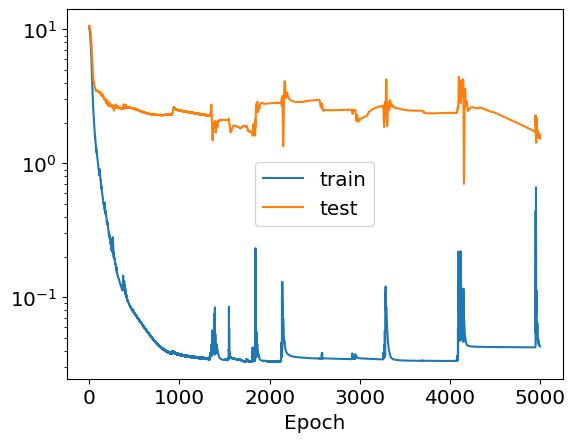

In [14]:
try:
    model.load_state_dict(torch.load("models/"+save_name))
    print("Loading saved network")
except FileNotFoundError:
    print("Training network")
    best_loss = np.inf
    test_losses = []
    train_losses = []

    def criterion(x, x_recon, x_enc, x_map):
        return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

    # Find the initial nn lists
    kd_tree_m = KDTree(model.GFN.mesh_m)
    nn_ns = [kd_tree_m.query(mesh, k=1)[1].astype('int') for mesh in meshes_train]
    nn_ms = [KDTree(mesh).query(model.GFN.mesh_m, k=1)[1].astype('int') for mesh in meshes_train]

    check_if_expanded = True
    # List to check if we need to agglomerate or expand
    need_agg = [True]*len(meshes_train)
    need_exp = [True]*len(meshes_train)
    
    loop = tqdm(range(epochs))
    for i in loop:
        # Put in training mode and reset gradients
        model.train()
        opt.zero_grad()

        params_train = params[train_trajs[0]]
        n_expansions = 0
        
        loss = 0
        
        for j in range(len(meshes_train)):
            # Load data
            U_train = sols_train[j][train_trajs[j]]
            params_train = params[train_trajs[j]]
            mesh_n = meshes_train[j]
            # Predict
            x_recon, x_enc, x_map, n_exp, n_agg = model(U_train, mesh_n, params_train, update_master=expand_master, nn_m=nn_ms[j], nn_n=nn_ns[j], expand=need_exp[j], agglomerate=need_agg[j])
            
            # If our master mesh is still changing, check if we had to expand or agglomerate this iteration
            # And update whether or not we will have to for future epochs accordingly
            if check_if_expanded:
                if n_exp == 0:
                    need_exp[j] = False
                if n_agg == 0:
                    need_agg[j] = False
            
            n_expansions += n_exp
            loss += criterion(U_train, x_recon, x_enc, x_map) * mesh_n.shape[0]
            
        # If we had an expansion, our master mesh changed and therefore we need to be be sure to expand and agglomerate
        # and also to update nearest neighbour lists due to this large master mesh
        # If there was no expansion, there will be no expansions for any future epochs so we stop checking
        if n_expansions > 0 and check_if_expanded and expand_master:
            kd_tree_m = KDTree(model.GFN.mesh_m)
            nn_ns = [kd_tree_m.query(mesh, k=1)[1].astype('int') for mesh in meshes_train]
            nn_ms = [KDTree(mesh).query(model.GFN.mesh_m, k=1)[1].astype('int') for mesh in meshes_train]
            need_agg = [True] * len(meshes_train)
            need_exp = [True] * len(meshes_train)
        else:
            check_if_expanded = False
        
        loss /= np.sum([k.shape[0] for k in meshes_train])
        loss.backward()
        opt.step()
        
        train_loss = loss.item()
        
        # Put model in evaluation mode for testing and don't track gradients here
        model.eval()

        test_loss = 0

        with torch.no_grad():
            params_test = params[test_trajs]

            for j in range(len(meshes_train)):
                U_test = sols_train[j][test_trajs]
                mesh_n = meshes_train[j]
                
                x_recon, x_enc, x_map, _, _ = model(U_test, mesh_n, params_test, update_master=expand_master, nn_m=nn_ms[j], nn_n=nn_ns[j], expand=need_exp[j], agglomerate=need_agg[j])
                
                test_loss += criterion(U_test, x_recon, x_enc, x_map).item() * mesh_n.shape[0]
            
            test_loss /= np.sum([k.shape[0] for k in meshes_train])
        
        loop.set_postfix({"Loss(training)": train_loss, "Loss(testing)": test_loss})
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if test_loss<best_loss:
            best_loss = test_loss
            best_epoch = i
            torch.save(model.state_dict(), "models/"+save_name)

    model.load_state_dict(torch.load("models/"+save_name))
    
    # plot training losses
    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.savefig('plots/loss_plot'+joined+run+'.png', bbox_inches='tight', dpi=500)

# Testing

In [15]:
# model = GFN_ROM(start_mesh, gfn_latent_size, latent_size, n_params, act, ae_sizes, mapper_sizes).to(dev)
# print(model.GFN.mesh_m.shape)

# # We do all of the possible expansions apriori in the preadaptive case
# # This is a preprocessing step so we don't do any speedup steps here
# if mode=='preadapt':
#     count = 0
#     while count!=0:
#         count = 0
#         for mesh_n in meshes_train:
#             n_exp, n_agg = model.GFN.reshape_weights(mesh_n, update_master=True)
#             count += n_exp
#     print(model.GFN.mesh_m.shape)
    
# model.load_state_dict(torch.load("models/"+save_name))

In [16]:
def evaluate_results(model, df_large, U_large, scale, params):
    with torch.no_grad():
        x_recon, x_enc, x_map, _, _  = model(U_large, df_large, params)
        x_rom = model.decoder(x_map)
        x_rom = x_rom@model.GFN.Wd_n + model.GFN.bd_n
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
    return Z, Z_net, x_enc, x_map

In [17]:
def print_results(Z, Z_net, x_enc, x_map):
    error_abs_list = list()
    norm_z_list = list()
    latents_error = list()

    for snap in range(Z.shape[1]):
        error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
        norm_z = np.linalg.norm(Z[:, snap], 2)
        error_abs_list.append(error_abs)
        norm_z_list.append(norm_z)
        lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
        latents_error.append(lat_err)

    latents_error = np.array(latents_error)
    print("\nMaximum relative error for latent  = ", max(latents_error))
    print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
    print("Minimum relative error for latent = ", min(latents_error))

    error = np.array(error_abs_list)
    norm = np.array(norm_z_list)
    rel_error = error/norm
    print("\nMaximum absolute error for field "+" = ", max(error))
    print("Mean absolute error for field "+" = ", sum(error)/len(error))
    print("Minimum absolute error for field "+" = ", min(error))
    print("\nMaximum relative error for field "+" = ", max(rel_error))
    print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
    print("Minimum relative error for field "+" = ", min(rel_error))
    return rel_error

In [18]:
def plot_fields(SNAP, Z, xx, yy, triang, params, fname):
    fig = plt.figure()    
    gs1 = gridspec.GridSpec(1, 1)
    ax = plt.subplot(gs1[0, 0])
    cs = ax.tricontourf(xx[:, SNAP], yy[:, SNAP], triang, Z[:, SNAP], 100, cmap=colormaps['jet'])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(cs, cax=cax)
    tick_locator = MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    plt.tight_layout()
    ax.set_aspect('equal', 'box')
    ax.set_title('Solution field for $\mu$ = '+str(np.around(params[SNAP].detach().numpy(), 2)))
    plt.savefig('plots/field_'+str(SNAP)+'_train'+joined+run+'_test'+fname+'.png', bbox_inches='tight', dpi=500)

In [19]:
N = 1
snapshots = np.arange(params[test_trajs].shape[0]).tolist()
np.random.shuffle(snapshots)

for i in range(len(test_mesh_names)):
    print('-'*40)
    print(f'TEST MESH: {test_mesh_names[i]}')
    scale, U = get_scaled_data(test_solution_names[i])
    U = U.to('cpu')
    # xx = scipy.io.loadmat("dataset/matrix"+test_fidelities[i])['xx']
    # yy = scipy.io.loadmat("dataset/matrix"+test_fidelities[i])['yy']
    # triang = scipy.io.loadmat("dataset/matrix"+test_fidelities[i])['T'].astype(int) - 1
    df = np.load("dataset/"+test_mesh_names[i])

    model.eval()
    model.to('cpu')
    Z, Z_net, x_enc, x_map = evaluate_results(model, df, U, scale, params.to('cpu'))
    error = abs(Z - Z_net)
    rel_error = print_results(Z, Z_net, x_enc, x_map)

    # for SNAP in snapshots[0:N]:
    #     if i == 0: plot_fields(SNAP, Z, xx, yy, triang, params.to('cpu'), test_fidelities[i]+"_solution")
    #     plot_fields(SNAP, Z_net, xx, yy, triang, params.to('cpu'), test_fidelities[i]+"_GCA")
    #     plot_fields(SNAP, error, xx, yy, triang, params.to('cpu'), test_fidelities[i]+"_error")
    np.savetxt('errors/relative_errors_train'+joined+run+'_test'+test_fidelities[i]+'.txt', [max(rel_error), sum(rel_error)/len(rel_error), min(rel_error)])
    print()

----------------------------------------
TEST MESH: reference_mesh_h3.npy
reconstruction error tensor(2.7673e-27)

Maximum relative error for latent  =  1.0259763283358194
Mean relative error for latent =  0.11729527162991288
Minimum relative error for latent =  0.019452409179495343

Maximum absolute error for field  =  63.96061004785777
Mean absolute error for field  =  8.957539852710097
Minimum absolute error for field  =  0.040802554316330224

Maximum relative error for field  =  0.24937946328888072
Mean relative error for field  =  0.08100577977850476
Minimum relative error for field  =  0.011493211187642335

----------------------------------------
TEST MESH: reference_mesh_h2.npy
reconstruction error tensor(1.4192e-27)

Maximum relative error for latent  =  1.0276543290395983
Mean relative error for latent =  0.11784960554058921
Minimum relative error for latent =  0.019452380284902645

Maximum absolute error for field  =  46.02524312742334
Mean absolute error for field  =  6.461